## UTILS

In [1]:
############
# Imports #

import torch
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import rasterio
import numpy as np
from torchvision import models, transforms
from custom_model import model_4D
from utils import ImageDataset, SaveFeatures, accuracy, imshow_transform
from torch.autograd import Variable
from skimage.transform import resize
from skimage.io import imshow
import wandb
import matplotlib.pyplot as plt 
import torch.optim.lr_scheduler as lr_scheduler

%matplotlib inline


###################
# Hyperparameters #

n_samples = 25000
n_samples_train = int(round(n_samples*0.8))
batch_size = 40
current_computer =  "ubuntu" # "macbook" 
layers_to_freeze = 41
lr = 0.00001
weight_decay=0.04
num_epochs = 10
im_size = 100
min_palsa_positive_samples = 10


##########################
# log hyperparams to w&b #

run = wandb.init(
    # Set the project where this run will be logged
    project="VGG_CAMs",
    # Track hyperparameters and run metadata
    config={
        "learning_rate": lr,
        "epochs": num_epochs,
        "batch_size": batch_size,
        "n_samples": n_samples,
        "layers_to_freeze": layers_to_freeze,
        "weight_decay": weight_decay,
        "im_size": im_size,
        "min_palsa_positive_samples": min_palsa_positive_samples
    },
    tags = ["MSELoss", "regressopm", "4D", "LRscheduler"]
)

#############
# Load data #

if current_computer == "ubuntu":
    hs_dir = '/home/nadjaflechner/Palsa_data/cropped_hillshade/hs'
    RGB_dir = '/home/nadjaflechner/Palsa_data/cropped_hillshade/rgb'
    labels_file = '/home/nadjaflechner/Palsa_data/cropped_hillshade/palsa_labels.csv'
elif current_computer == "macbook":
    hs_dir = '/Users/nadja/Documents/UU/Thesis/Data/cropped_hillshade/hs'
    RGB_dir = '/Users/nadja/Documents/UU/Thesis/Data/cropped_hillshade/rgb'
    labels_file = '/Users/nadja/Documents/UU/Thesis/Data/cropped_hillshade/palsa_labels.csv'

# Load the labels from the CSV file
if min_palsa_positive_samples > 0:
    labels_df = pd.read_csv(labels_file, index_col=0)
    drop_range = labels_df[ (labels_df['palsa_percentage'] > 0) & (labels_df['palsa_percentage'] <= 10) ].index
    labels_df.drop(drop_range, inplace=True)
    labels_df = labels_df.head(n_samples)
else: 
    labels_df = pd.read_csv(labels_file, index_col=0).head(n_samples)


# Split the dataset into training and validation sets
train_df = labels_df.head(n_samples_train)
val_df = labels_df.drop(train_df.index)

# Create the datasets and data loaders
train_dataset = ImageDataset(hs_dir, RGB_dir, train_df)
val_dataset = ImageDataset(hs_dir, RGB_dir, val_df)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: nadja-flechner (nadjaflechner). Use `wandb login --relogin` to force relogin


In [2]:
################
# Define model 

model = model_4D()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay) 
# scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.3, total_iters=10)
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.92)
loss_function = nn.MSELoss()


In [3]:
##################
# Training loop #

# adapted from https://github.com/tony-mtz/CAM/blob/master/network/net.py

mean_train_losses = []
mean_val_losses = []

mean_train_acc = []
mean_val_acc = []

min_val_loss = 100

for epoch in range(num_epochs):
    print('EPOCH: ',epoch+1)

    train_acc = []
    val_acc = []

    running_loss = 0.0
    model.train()
    train_batch_count = 0

    for batch_idx, (images, labels) in enumerate(train_loader):     

        # load images and labels 
        images = Variable(images).to(device)
        labels = Variable(labels.float()).to(device)

        # train batch   
        outputs = model(images)   
        optimizer.zero_grad()
        loss = loss_function(outputs, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()  

        # calculate loss and accuracy
        # train_acc.append(accuracy(outputs.squeeze(), labels.float()))
        running_loss += loss.item()
        train_batch_count += 1
   
    model.eval()
    val_batch_count = 0
    val_running_loss = 0.0
    model.to(device)

    for batch_idx, (images, labels) in enumerate(val_loader):     
        # inference   
        images = Variable(images).to(device)
        labels = Variable(labels.float()).to(device)
        outputs = model(images)

        loss = loss_function(outputs, labels.unsqueeze(1))

        # val_acc.append(accuracy(outputs.squeeze(), labels.float()))
        val_running_loss += loss.item()
        val_batch_count +=1

    scheduler.step()

    # update losses and accuracies 

    # mean_train_acc.append(np.mean(train_acc))
    # # mean_val_acc.append(np.mean(val_acc))
    mean_train_losses.append(running_loss/train_batch_count)
    mean_val_losses.append(val_running_loss/val_batch_count)

    # # wandb.log({"train_accuracy": np.mean(train_acc)})
    # # wandb.log({"val_accuracy": np.mean(val_acc)})
    wandb.log({"train_loss": running_loss/train_batch_count})
    wandb.log({"val_loss": val_running_loss/val_batch_count})

    if val_running_loss/val_batch_count < min_val_loss:
        best_model = model.state_dict()
        min_val_loss = val_running_loss/val_batch_count

torch.save(best_model, '/home/nadjaflechner/models/model.pth')
artifact = wandb.Artifact('model', type='model')
artifact.add_file('/home/nadjaflechner/models/model.pth')
run.log_artifact(artifact)


EPOCH:  1
EPOCH:  2
EPOCH:  3
EPOCH:  4
EPOCH:  5
EPOCH:  6
EPOCH:  7
EPOCH:  8
EPOCH:  9
EPOCH:  10


<Artifact model>

[[ 3.68441790e-02  6.15850389e-02  4.63015288e-02  4.59083207e-02
   4.89508957e-02  4.81681675e-02  4.76713032e-02  4.84059937e-02
   4.88239229e-02  4.93103750e-02  5.12048975e-02  5.07308468e-02
   4.70214039e-02  5.01411334e-02  4.71722707e-02  4.22593914e-02
   3.25649716e-02  2.03466807e-02  8.19651969e-03 -3.69595177e-03
  -2.80594826e-03 -8.55380390e-03 -7.81029239e-02 -6.37277186e-01
   7.24210858e-01]
 [ 6.46350235e-02  8.54820907e-02  7.58716315e-02  7.86296427e-02
   8.33183080e-02  8.63639191e-02  8.67269039e-02  8.53420794e-02
   8.36532637e-02  8.47506225e-02  8.43601599e-02  8.24434310e-02
   8.22383389e-02  8.23937133e-02  7.94981271e-02  6.98833466e-02
   5.99360764e-02  4.12383080e-02  3.48162502e-02  2.96705384e-02
   4.33967859e-02  5.68867326e-02  5.20435721e-02 -8.29995692e-01
   1.59058428e+00]
 [ 6.47295862e-02  7.62637854e-02  5.26202284e-02  4.24372889e-02
   4.21409495e-02  4.33334038e-02  4.82849143e-02  5.00138216e-02
   5.32087572e-02  5.59241772e-02  5.4

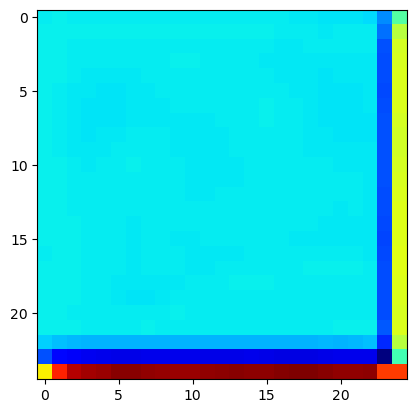

In [14]:
####################
# generating CAMs #

#change batch size to 1 to grab one image at a time
valid_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, 
                                          shuffle=True,
                                          num_workers=1)

# Load best model to produce CAMs with
model.load_state_dict(best_model)
model.eval()

# Save 10 palsa images
# palsa_imgs = 0
# for palsa_cam in range(100):

im, lab = next(iter(valid_loader))

#get the last convolution
sf = SaveFeatures(model.features[-4])
model.eval()

if lab == 0:
    # palsa_imgs+= 1
    im = Variable(im).to(device)
    outputs = model(im).to(device)
    res = torch.argmax(outputs.data).cpu().detach().numpy()

    # generate CAM
    sf.remove()
    arr = sf.features.cpu().detach().squeeze(0).squeeze(0).numpy()
    print(arr, arr.shape)
    # arr1 = arr[0]
    # ans_palsa = np.dot(np.rollaxis(arr1,0,3), [0])

    plt.imshow(arr, cmap='jet')
    plt.show()

    # CAM = resize(arr, (im_size*2,im_size*2))
    
    # # Plot image with CAM
    # cpu_img = im.squeeze().cpu().detach().permute(1,2,0).long().numpy()

    # fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,7))

    # ax1.imshow(cpu_img)
    # ax1.set_xticks([])
    # ax1.set_yticks([])
    # ax1.set_title('original image')

    # ax2.imshow(cpu_img)
    # ax2.imshow(CAM, alpha=.4, cmap='jet')
    # ax2.set_xticks([])
    # ax2.set_yticks([])
    # ax2.set_title('image with CAM')

    # plt.tight_layout()
    # plt.show()

    # wandb.log({'generated_CAM': fig})

# if palsa_imgs == 10:
#     break


In [ ]:
wandb.finish()

### LOGGING FORGOTTEN CAMS FROM SAVED MODELS

In [ ]:
# to load model again: 

run = wandb.init(project= 'VGG_CAMs', id= 'v6ax9crk', resume = 'must')

In [ ]:

artifact = run.use_artifact('nadjaflechner/VGG_CAMs/model:v9', type='model')
artifact_dir = artifact.download()
state_dict = torch.load(f"{artifact_dir}/model.pth")
model.load_state_dict(state_dict)
